<h1>1. Can we predict whether an order will be completed or cancelled based on historical data?</h1>

Confusion Matrix:
[[44439 22421]
 [19239 58733]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68     66860
           1       0.72      0.75      0.74     77972

    accuracy                           0.71    144832
   macro avg       0.71      0.71      0.71    144832
weighted avg       0.71      0.71      0.71    144832

AUC: 0.7693


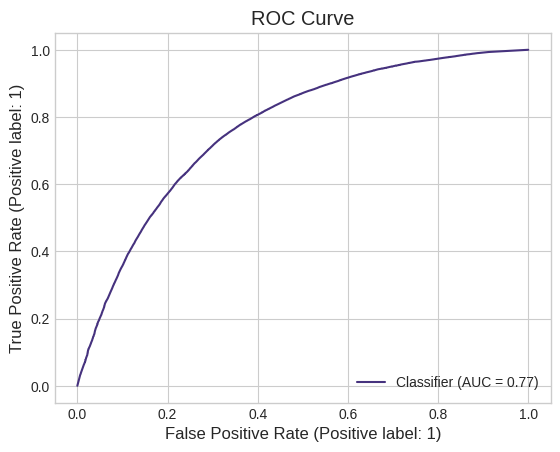


Top 20 Feature Importances:
grand_total                        0.269728
price                              0.242522
discount_amount                    0.172455
payment_method_cash_on_delivery    0.146329
payment_method_payment_gateway     0.041107
payment_method_easypay             0.029558
payment_method_credit              0.018097
qty_ordered                        0.013863
category_Others                    0.010231
payment_method_jazzcash            0.008681
category_Mobiles & Tablets         0.008280
category_Gifts                     0.006749
category_Superstore                0.006568
category_Men's Fashion             0.004839
category_Beauty & Grooming         0.003691
category_Women's Fashion           0.003527
category_Entertainment             0.003518
category_Computing                 0.002433
category_Home & Living             0.002300
category_Health & Sports           0.002190
dtype: float64


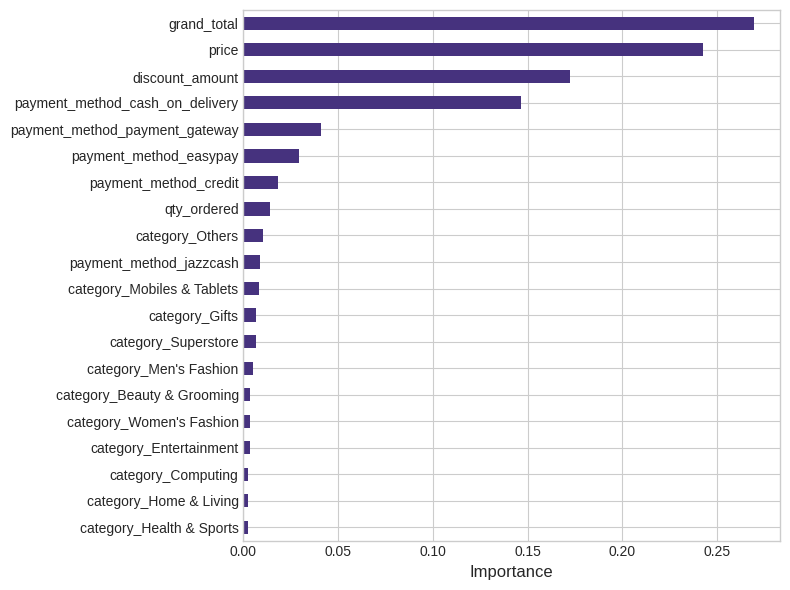


Directional Analysis for Top 4 Features:

*grand_total*
  Mean:  Canceled = 10,027.07 | Complete = 3,973.33
  Median:  Canceled = 1,499.00 | Complete = 699.00

*price*
  Mean:  Canceled = 9,239.00 | Complete = 3,956.78
  Median:  Canceled = 1,299.00 | Complete = 699.00

*discount_amount*
  Mean:  Canceled = 503.90 | Complete = 426.07
  Median:  Canceled = 0.00 | Complete = 0.00

*payment_method_cash_on_delivery*
  Cash on Delivery – Cancellation Rate: 27.97%, Completion Rate: 72.03%


--- Analysis of Top 4 Features ---
Our Random Forest assigned these importance scores to the top 4 features:
  grand_total                        0.2697
  price                              0.2425
  discount_amount                    0.1725
  payment_method_cash_on_delivery    0.1463

1. grand_total (0.2697)
   - Larger total-order values push the model strongly toward predicting CANCELLATION.
     (Mean canceled ≈ 10,027 vs. mean complete ≈ 3,973; median 1,499 vs. 699.)

2. price (0.2425)
   - Higher un

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay
)

# 1. Load and filter
df = pd.read_csv('/kaggle/input/datascience/preprocessed_dataset.csv',
                 parse_dates=['created_at'], low_memory=False)
df = df[df['status'].isin(['complete', 'canceled'])].copy()
df['is_complete'] = (df['status'] == 'complete').astype(int)

# 2. Select features & encode
features = ['category', 'payment_method', 'price', 'qty_ordered', 'discount_amount', 'grand_total']
X = pd.get_dummies(df[features], drop_first=True)
y = df['is_complete']

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 4. Train model
model = RandomForestClassifier(
    n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1
)
model.fit(X_train, y_train)

# 5. Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC Curve')
plt.show()

# 6. Feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
top = importances.sort_values(ascending=False).head(20)

print("\nTop 20 Feature Importances:")
print(top)

plt.figure(figsize=(8, 6))
top.plot.barh()
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# --- after printing Top 20 feature importances ---

# 7. Directional Analysis for Top 4 Features
top4 = top.index[:4].tolist()
print("\nDirectional Analysis for Top 4 Features:")
for feature in top4:
    print(f"\n*{feature}*")
    if feature in ['grand_total', 'price', 'discount_amount']:
        stats = df.groupby('status')[feature].agg(['mean', 'median'])
        # formatted print
        for stat in ['mean', 'median']:
            vals = stats[stat].apply(lambda x: f"{x:,.2f}")
            print(f"  {stat.title()}:  Canceled = {vals['canceled']} | Complete = {vals['complete']}")
    elif feature == 'payment_method_cash_on_delivery':
        # compute cancellation/completion rates for COD
        rates = df[df['payment_method'] == 'cash_on_delivery']['status'].value_counts(normalize=True)
        can = rates.get('canceled', 0)
        comp = rates.get('complete', 0)
        print(f"  Cash on Delivery – Cancellation Rate: {can:.2%}, Completion Rate: {comp:.2%}")
    else:
        print("  (No directional analysis implemented for this feature.)")



print("\n\n--- Analysis of Top 4 Features ---")
print("Our Random Forest assigned these importance scores to the top 4 features:")
print("  grand_total                        0.2697")
print("  price                              0.2425")
print("  discount_amount                    0.1725")
print("  payment_method_cash_on_delivery    0.1463\n")

print("1. grand_total (0.2697)")
print("   - Larger total-order values push the model strongly toward predicting CANCELLATION.")
print("     (Mean canceled ≈ 10,027 vs. mean complete ≈ 3,973; median 1,499 vs. 699.)\n")

print("2. price (0.2425)")
print("   - Higher unit prices also increase cancellation likelihood.")
print("     (Mean canceled ≈ 9,239 vs. mean complete ≈ 3,957; median 1,299 vs. 699.)\n")

print("3. discount_amount (0.1725)")
print("   - Discounts play a modest role. Most orders have no discount, so directional effect is weak.")
print("     (Mean canceled ≈ 504 vs. mean complete ≈ 426; both medians = 0.)\n")

print("4. payment_method_cash_on_delivery (0.1463)")
print("   - Using Cash on Delivery pushes strongly toward COMPLETION.")
print("     (Cancellation Rate ≈ 28%; Completion Rate ≈ 72%.)\n")

print("Summary:")
print("  - Order size (grand_total & price) is the strongest driver of cancellations.")
print("  - discount_amount has minimal directional impact.")
print("  - payment_method_cash_on_delivery is a reliable lever to boost completions.")

## 2. Can we group our customer base into clusters? What does that reveal about our target audience? ###

Loading dataset from: /kaggle/input/datascience/preprocessed_dataset.csv
Dataset loaded successfully. Original shape: (582292, 21)
Dropped 11 rows with missing 'customer_id'.
Found 115081 unique customers.

Aggregating purchasing data per customer...
Customer aggregated data shape: (115081, 8)

Scaling features using StandardScaler...
Scaled features shape: (115081, 7)

Calculating WCSS for Elbow Method...
Elbow method calculation time: 7.48 seconds


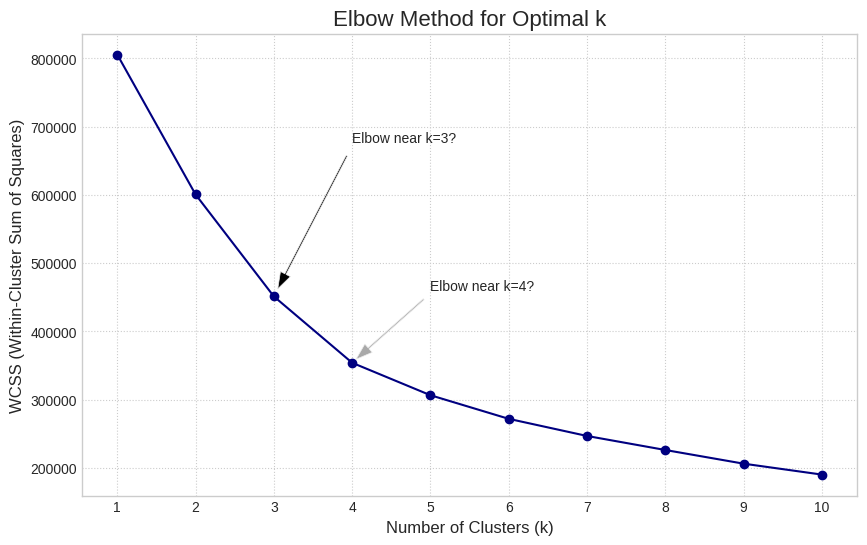

Interpret the plot: Look for point(s) where the rate of decrease slows down (the 'elbow').

Calculating Silhouette Scores...
Using sample of 15000 for Silhouette (total: 115081)
  k=2, Silhouette Score: N/A (only 1 cluster assigned).
  k=3, Silhouette Score: 0.9749
  k=4, Silhouette Score: 0.8007
  k=5, Silhouette Score: 0.7857
  k=6, Silhouette Score: 0.7762
  k=7, Silhouette Score: 0.7684
  k=8, Silhouette Score: 0.7097
  k=9, Silhouette Score: 0.7114
  k=10, Silhouette Score: 0.7136
Silhouette score calculation time: 25.31 seconds


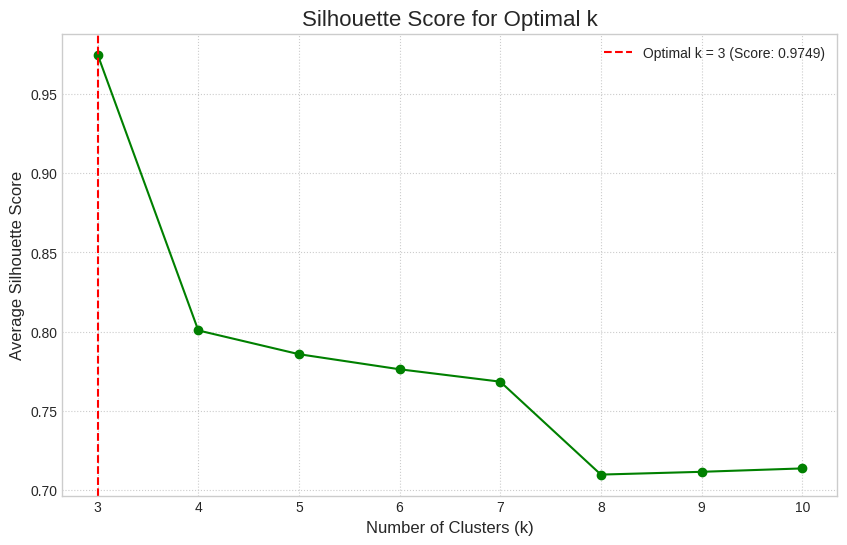


Optimal k suggested by Silhouette Score: 3

Selected k = 3 based on Silhouette score.

Running K-Means clustering with k=3...
K-Means fitting completed in 0.39 seconds.

Cluster labels assigned.

Cluster distribution:
cluster
0    115004
1        76
2         1
Name: count, dtype: int64

--- Analyzing Cluster Characteristics ---

Cluster Profile (Mean Values & Size):


,total_spending,frequency,average_order_value,total_quantity,average_quantity_per_order,total_discount,average_discount_per_order,cluster_size
cluster,,,,,,,,
0,"30,654.28",3.22,"7,598.78",5.92,1.73,"2,236.98",500.49,"115,004.00"
1,"5,054,720.83",496.96,"31,659.88",923.50,4.07,"139,176.43",429.31,76.00
2,"17,888,000.00",1.00,"17,888,000.00","2,000.00","2,000.00",0.00,0.00,1.00
Overall Mean,"34,127.36",3.54,"7,770.04",6.55,1.75,"2,327.39",500.43,"115,081.00"



--- Visualizing Clusters ---
Note: Log scale for Spending skipped due to non-positive values in sample.


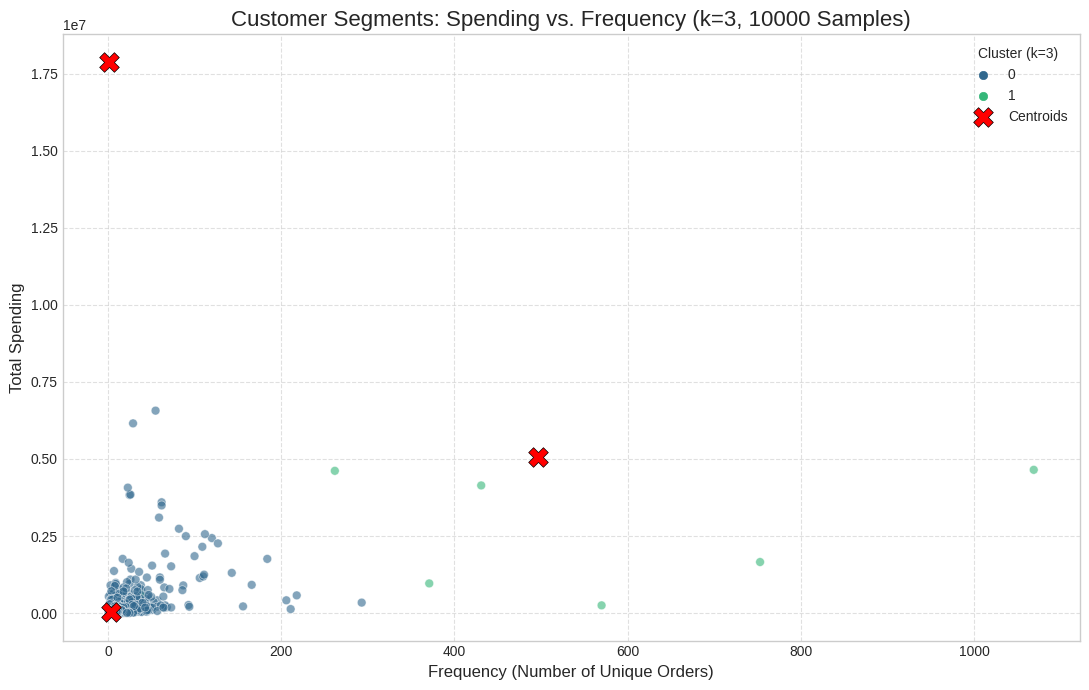


--- Visualizing Feature Distributions by Cluster ---


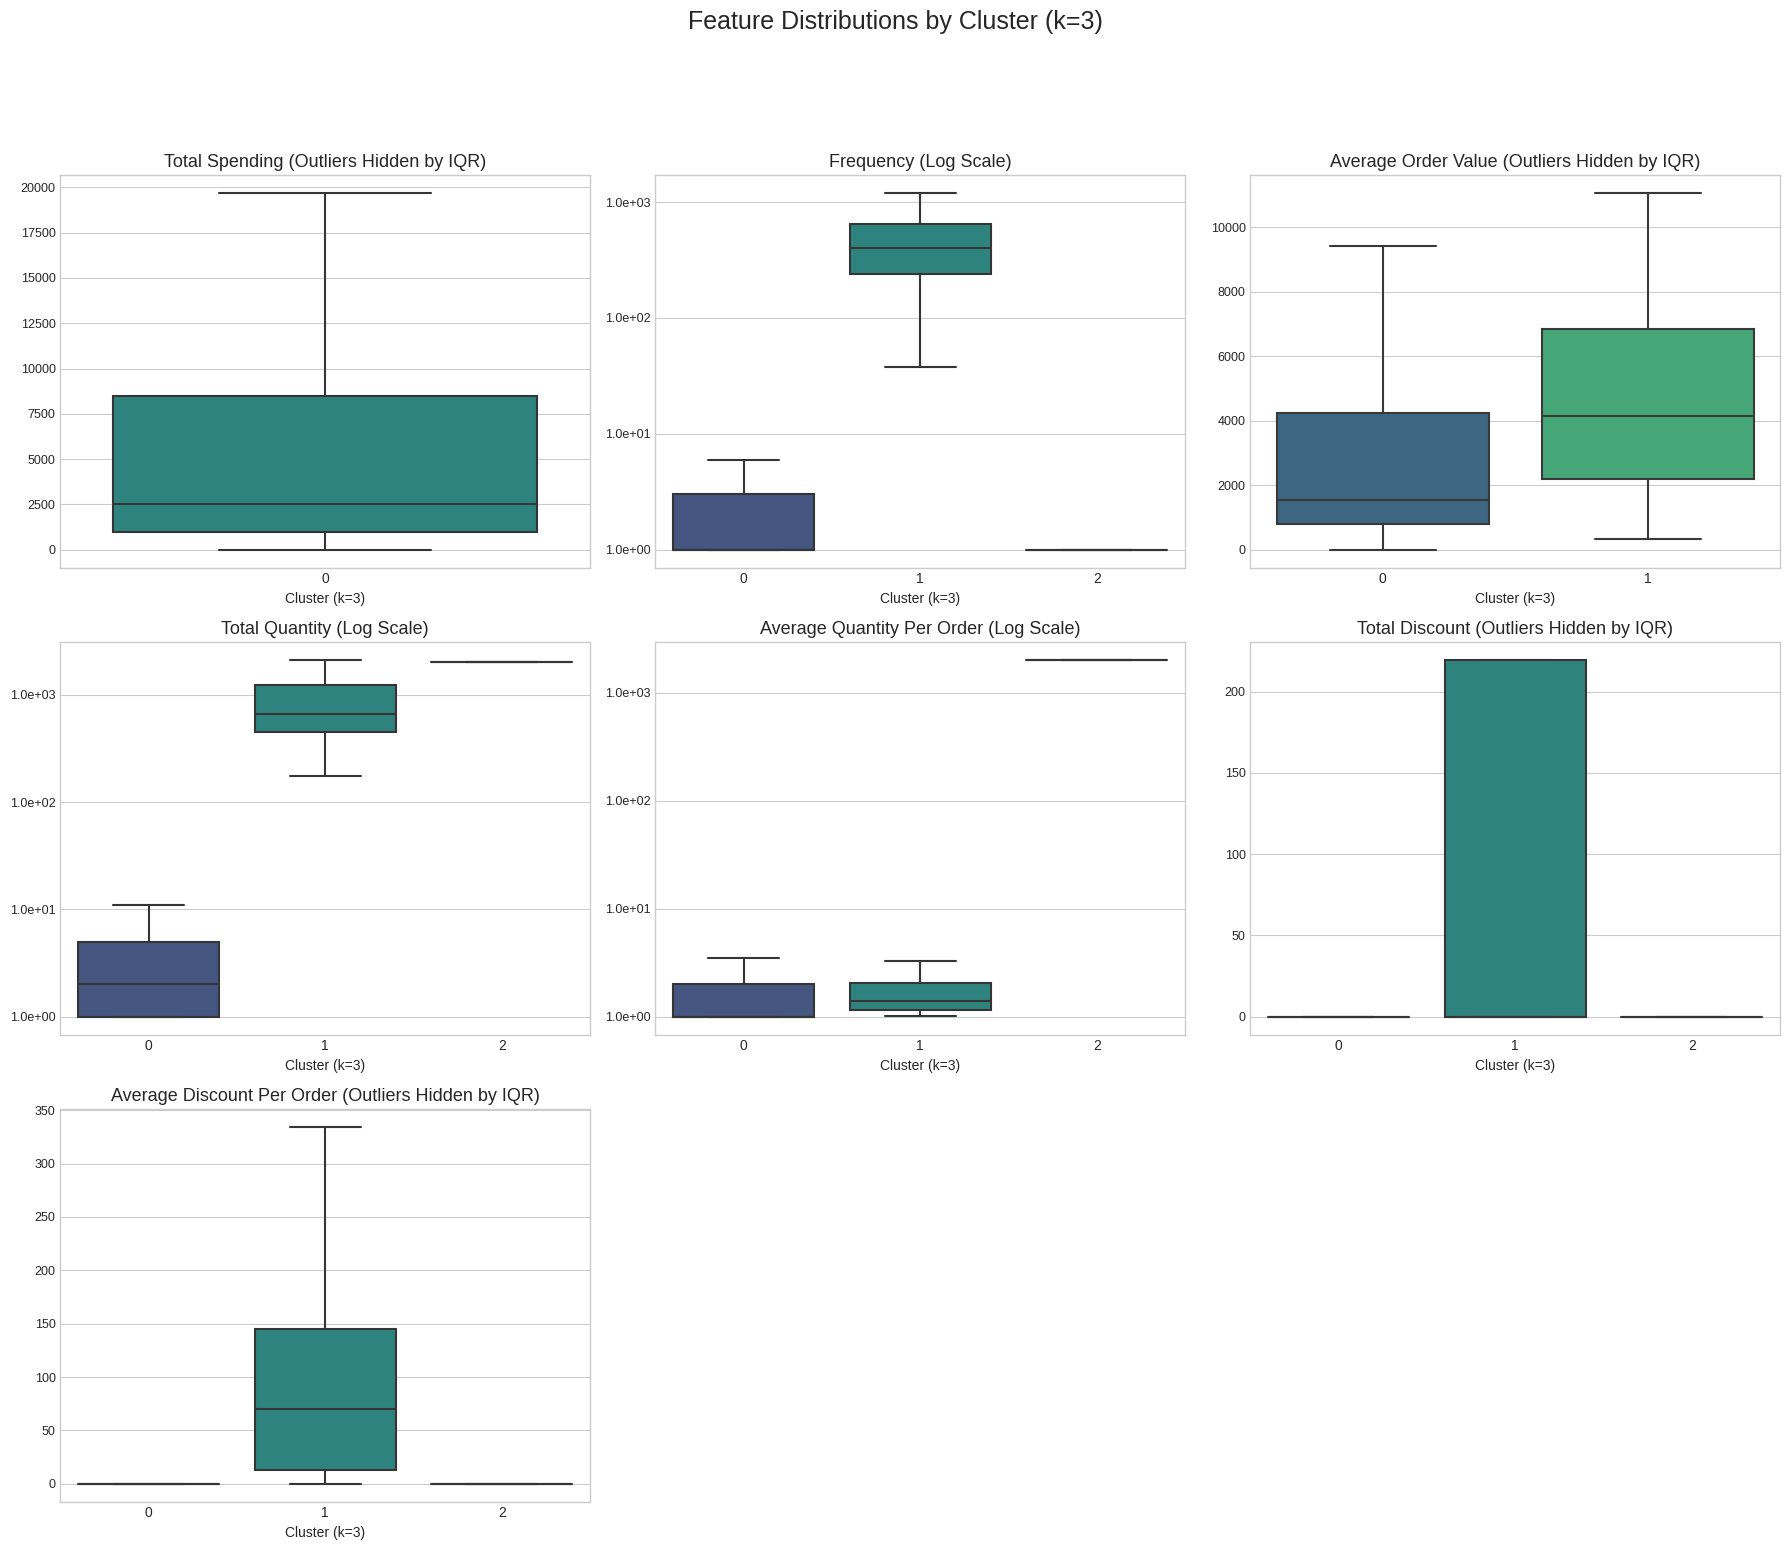


--- Cluster Interpretation Summary (k=3) ---

Cluster 0 (Size: 115004, 99.9% of total)
  Key Traits: Average Spending, Average Frequency, Average AOV
  Suggested Profile: Core Customers

Cluster 1 (Size: 76, 0.1% of total)
  Key Traits: Very High Spending, Very Frequent, High AOV
  Suggested Profile: VIP Loyalists

Cluster 2 (Size: 1, 0.0% of total)
  Key Traits: Very High Spending, Very Infrequent, High AOV
  Suggested Profile: Big Spenders (Occasional)

Note: Thresholds and segment names are heuristic suggestions based on averages.

--- Customer Segmentation Analysis Complete ---


In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
import os
import time
from IPython.display import display, HTML

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')


DATASET_PATH = '/kaggle/input/datascience/preprocessed_dataset.csv'
CUSTOMER_ID_COL = 'customer_id'
ORDER_ID_COL = 'increment_id'

AGGREGATION_METRICS = {
    'total_spending': ('grand_total', 'sum'),
    'frequency': (ORDER_ID_COL, 'nunique'),
    'total_quantity': ('qty_ordered', 'sum'),
    'total_discount': ('discount_amount', 'sum'),
}

FEATURES_FOR_CLUSTERING_BASE = [
    'total_spending',
    'frequency',
    'average_order_value',
    'total_quantity',
    'average_quantity_per_order',
    'total_discount',
    'average_discount_per_order'
]

MAX_K_TO_TEST = 10
SILHOUETTE_SAMPLE_SIZE = 15000
DEFAULT_K = 3



if not os.path.exists(DATASET_PATH):
    print(f"Error: Dataset file not found at {DATASET_PATH}")
    exit()
else:
    print(f"Loading dataset from: {DATASET_PATH}")
    try:
        df = pd.read_csv(DATASET_PATH)
        print(f"Dataset loaded successfully. Original shape: {df.shape}")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        exit()


if CUSTOMER_ID_COL not in df.columns:
    print(f"Error: Customer ID column '{CUSTOMER_ID_COL}' not found.")
    exit()

original_rows = df.shape[0]
df.dropna(subset=[CUSTOMER_ID_COL], inplace=True)
rows_dropped = original_rows - df.shape[0]
if rows_dropped > 0:
    print(f"Dropped {rows_dropped} rows with missing '{CUSTOMER_ID_COL}'.")

unique_customers = df[CUSTOMER_ID_COL].nunique()
print(f"Found {unique_customers} unique customers.")



print("\nAggregating purchasing data per customer...")
required_agg_cols = [CUSTOMER_ID_COL, ORDER_ID_COL] + [val[0] for val in AGGREGATION_METRICS.values()]
missing_req_cols = [col for col in required_agg_cols if col not in df.columns]
if missing_req_cols:
    print(f"Error: Missing required columns for aggregation: {list(set(missing_req_cols))}")
    exit()


customer_agg = df.groupby(CUSTOMER_ID_COL).agg(**AGGREGATION_METRICS).reset_index()


if 'frequency' in customer_agg.columns and 'total_spending' in customer_agg.columns:
    customer_agg['average_order_value'] = customer_agg.apply(
        lambda row: row['total_spending'] / row['frequency'] if row['frequency'] > 0 else 0, axis=1)
if 'frequency' in customer_agg.columns and 'total_quantity' in customer_agg.columns:
    customer_agg['average_quantity_per_order'] = customer_agg.apply(
        lambda row: row['total_quantity'] / row['frequency'] if row['frequency'] > 0 else 0, axis=1)
if 'frequency' in customer_agg.columns and 'total_discount' in customer_agg.columns:
    customer_agg['average_discount_per_order'] = customer_agg.apply(
        lambda row: row['total_discount'] / row['frequency'] if row['frequency'] > 0 else 0, axis=1)

print(f"Customer aggregated data shape: {customer_agg.shape}")


actual_features = [f for f in FEATURES_FOR_CLUSTERING_BASE if f in customer_agg.columns]
if not actual_features:
    print("Error: No clustering features exist in the aggregated data.")
    exit()
elif len(actual_features) < len(FEATURES_FOR_CLUSTERING_BASE):
    print(f"Warning: Using subset of features: {actual_features}")

X_clustering = customer_agg[actual_features].copy()


if X_clustering.isnull().sum().sum() > 0:
    print("Warning: Filling NaN values with 0 before scaling.")
    X_clustering = X_clustering.fillna(0)

infinite_mask = np.isinf(X_clustering).any()
if infinite_mask.any():
    print("Warning: Replacing infinite values with 0 before scaling.")
    X_clustering = X_clustering.replace([np.inf, -np.inf], 0)


print("\nScaling features using StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)
print(f"Scaled features shape: {X_scaled.shape}")



print("\nCalculating WCSS for Elbow Method...")
wcss = []
possible_k_elbow = range(1, MAX_K_TO_TEST + 1)
start_elbow = time.time()

for k_val in possible_k_elbow:
    kmeans_test = KMeans(n_clusters=k_val, init='k-means++', random_state=42, n_init=10)
    kmeans_test.fit(X_scaled)
    wcss.append(kmeans_test.inertia_)

end_elbow = time.time()
print(f"Elbow method calculation time: {end_elbow - start_elbow:.2f} seconds")

plt.figure(figsize=(10, 6))
plt.plot(possible_k_elbow, wcss, marker='o', linestyle='-', color='navy')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
plt.xticks(possible_k_elbow)
if len(wcss) > 2:
    plt.annotate('Elbow near k=3?', xy=(3, wcss[2]), xytext=(4, wcss[2]*1.5),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                 fontsize=10)
if len(wcss) > 3:
    plt.annotate('Elbow near k=4?', xy=(4, wcss[3]), xytext=(5, wcss[3]*1.3),
                 arrowprops=dict(facecolor='darkgrey', shrink=0.05, width=1, headwidth=8),
                 fontsize=10)

plt.grid(True, linestyle=':')
plt.show()
print("Interpret the plot: Look for point(s) where the rate of decrease slows down (the 'elbow').")


print("\nCalculating Silhouette Scores...")
silhouette_scores = []
possible_k_sil = range(2, MAX_K_TO_TEST + 1)
start_sil = time.time()
optimal_k_silhouette = -1


X_silhouette = X_scaled
indices_silhouette = None
if SILHOUETTE_SAMPLE_SIZE is not None and X_scaled.shape[0] > SILHOUETTE_SAMPLE_SIZE:
    print(f"Using sample of {SILHOUETTE_SAMPLE_SIZE} for Silhouette (total: {X_scaled.shape[0]})")
    indices_silhouette = np.random.choice(X_scaled.shape[0], SILHOUETTE_SAMPLE_SIZE, replace=False)
    X_silhouette = X_scaled[indices_silhouette]
else:
     print(f"Using full dataset ({X_scaled.shape[0]} points) for Silhouette.")

for k_val in possible_k_sil:
    kmeans_test = KMeans(n_clusters=k_val, init='k-means++', random_state=42, n_init=10)
    cluster_labels_full = kmeans_test.fit_predict(X_scaled)

    if indices_silhouette is not None:
        labels_for_silhouette = cluster_labels_full[indices_silhouette]
    else:
        labels_for_silhouette = cluster_labels_full

    score = -1
    if len(np.unique(labels_for_silhouette)) > 1:
         try:
            score = silhouette_score(X_silhouette, labels_for_silhouette)
            print(f"  k={k_val}, Silhouette Score: {score:.4f}")
         except Exception as e:
            print(f"  k={k_val}, Silhouette Calc Error: {e}")
            score = -99
    else:
         print(f"  k={k_val}, Silhouette Score: N/A (only 1 cluster assigned).")

    silhouette_scores.append(score)

end_sil = time.time()
print(f"Silhouette score calculation time: {end_sil - start_sil:.2f} seconds")


valid_indices = [i for i, s in enumerate(silhouette_scores) if s > -1]
if valid_indices:
    valid_k = [possible_k_sil[i] for i in valid_indices]
    valid_scores = [silhouette_scores[i] for i in valid_indices]

    if valid_scores:
        plt.figure(figsize=(10, 6))
        plt.plot(valid_k, valid_scores, marker='o', linestyle='-', color='green')
        plt.title('Silhouette Score for Optimal k', fontsize=16)
        plt.xlabel('Number of Clusters (k)', fontsize=12)
        plt.ylabel('Average Silhouette Score', fontsize=12)
        plt.xticks(valid_k)

        max_score_index = np.argmax(valid_scores)
        optimal_k_silhouette = valid_k[max_score_index]
        plt.axvline(optimal_k_silhouette, color='red', linestyle='--',
                    label=f'Optimal k = {optimal_k_silhouette} (Score: {valid_scores[max_score_index]:.4f})')
        plt.legend()
        plt.grid(True, linestyle=':')
        plt.show()
        print(f"\nOptimal k suggested by Silhouette Score: {optimal_k_silhouette}")
    else:
         print("\nNo valid Silhouette scores available to plot.")
else:
    print("\nCould not plot Silhouette Scores (no valid scores calculated).")


if optimal_k_silhouette != -1 and optimal_k_silhouette >= 2:
    chosen_k = optimal_k_silhouette
    print(f"\nSelected k = {chosen_k} based on Silhouette score.")
else:
    chosen_k = DEFAULT_K
    print(f"\nUsing default k = {chosen_k}. Review Elbow plot manually.")



if chosen_k < 2:
    print(f"Error: Invalid number of clusters selected (k={chosen_k}). Must be >= 2.")
    exit()

print(f"\nRunning K-Means clustering with k={chosen_k}...")
kmeans = KMeans(n_clusters=chosen_k, init='k-means++', random_state=42, n_init=10)

if X_scaled.shape[0] == 0:
     print("Error: Scaled data is empty.")
     exit()

try:
    start_kmeans = time.time()
    cluster_labels = kmeans.fit_predict(X_scaled)
    end_kmeans = time.time()
    print(f"K-Means fitting completed in {end_kmeans - start_kmeans:.2f} seconds.")

    customer_agg['cluster'] = cluster_labels
    print("\nCluster labels assigned.")
    print("\nCluster distribution:")
    cluster_counts = customer_agg['cluster'].value_counts().sort_index()
    print(cluster_counts)

except Exception as e:
     print(f"An error occurred during K-Means fitting: {e}")
     exit()



if 'cluster' not in customer_agg.columns:
    print("Error: Cluster labels not found. Skipping analysis.")
else:
    print("\n--- Analyzing Cluster Characteristics ---")
    cluster_analysis = customer_agg.groupby('cluster')[actual_features].mean()
    cluster_analysis['cluster_size'] = cluster_counts
    overall_mean = customer_agg[actual_features].mean()
    overall_mean['cluster_size'] = customer_agg.shape[0]
    cluster_analysis.loc['Overall Mean'] = overall_mean

    print("\nCluster Profile (Mean Values & Size):")
    display(cluster_analysis.style.format("{:,.2f}"))

    print("\n--- Visualizing Clusters ---")


    plt.figure(figsize=(11, 7))
    plot_sample_size = min(len(customer_agg), 10000)
    scatter_data = customer_agg.sample(plot_sample_size, random_state=42)

    sns.scatterplot(data=scatter_data, x='frequency', y='total_spending', hue='cluster',
                    palette='viridis', s=40, alpha=0.6, legend='full')

    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=actual_features)
    if 'frequency' in centroids_df.columns and 'total_spending' in centroids_df.columns:
        plt.scatter(centroids_df['frequency'], centroids_df['total_spending'], marker='X', s=200,
                    c='red', edgecolor='black', label='Centroids', zorder=5)

    plt.title(f'Customer Segments: Spending vs. Frequency (k={chosen_k}, {plot_sample_size} Samples)', fontsize=16)
    plt.xlabel('Frequency (Number of Unique Orders)', fontsize=12)
    plt.ylabel('Total Spending', fontsize=12)


    can_log_scale_x = (scatter_data['frequency'] > 0).all()
    can_log_scale_y = (scatter_data['total_spending'] > 0).all()
    if can_log_scale_x and can_log_scale_y:
         plt.xscale('log')
         plt.yscale('log')
         plt.xlabel('Frequency (Log Scale)', fontsize=12)
         plt.ylabel('Total Spending (Log Scale)', fontsize=12)
         plt.title(f'Customer Segments: Spending vs. Frequency (Log Scale, k={chosen_k}, {plot_sample_size} Samples)', fontsize=16)
    elif not can_log_scale_x:
         print("Note: Log scale for Frequency skipped due to non-positive values in sample.")
    elif not can_log_scale_y:
         print("Note: Log scale for Spending skipped due to non-positive values in sample.")

    plt.legend(title=f'Cluster (k={chosen_k})')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


    print("\n--- Visualizing Feature Distributions by Cluster ---")
    num_features_plot = len(actual_features)
    ncols_plot = min(3, num_features_plot)
    nrows_plot = int(np.ceil(num_features_plot / ncols_plot))
    fig, axes = plt.subplots(nrows=nrows_plot, ncols=ncols_plot, figsize=(ncols_plot * 6, nrows_plot * 5), squeeze=False)
    axes = axes.flatten()

    for i, feature in enumerate(actual_features):
        ax = axes[i]
        plot_data = customer_agg[['cluster', feature]].copy()
        log_scale_applied = False
        title_suffix = ""

        if (plot_data[feature] > 0).all():
            try:
                ax.set_yscale('log')
                log_scale_applied = True
                title_suffix = " (Log Scale)"
                ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
            except Exception as e:
                 print(f"Could not apply log scale to {feature}: {e}")
                 log_scale_applied = False

        if not log_scale_applied:
            Q1 = plot_data[feature].quantile(0.25)
            Q3 = plot_data[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            plot_data_filtered = plot_data[(plot_data[feature] >= lower_bound) & (plot_data[feature] <= upper_bound)]

            if len(plot_data_filtered) / len(plot_data) > 0.1:
                 plot_data_to_show = plot_data_filtered
                 title_suffix = " (Outliers Hidden by IQR)"
            else:
                 plot_data_to_show = plot_data
                 title_suffix = " (Outliers Present)"
            ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
        else:
             plot_data_to_show = plot_data

        sns.boxplot(data=plot_data_to_show, x='cluster', y=feature, ax=ax, palette='viridis', showfliers=False)

        ax.set_title(f'{feature.replace("_", " ").title()}{title_suffix}', fontsize=13)
        ax.set_xlabel(f'Cluster (k={chosen_k})', fontsize=10)
        ax.set_ylabel('')
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=9)


    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'Feature Distributions by Cluster (k={chosen_k})', fontsize=18, y=1.03)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


    print(f"\n--- Cluster Interpretation Summary (k={chosen_k}) ---")
    analysis_sorted = cluster_analysis.drop('Overall Mean').sort_index()
    overall_means = cluster_analysis.loc['Overall Mean']

    thresholds = {'Very High': 1.75, 'High': 1.15, 'Low': 0.85, 'Very Low': 0.5}

    for cluster_id in analysis_sorted.index:
        cluster_data = analysis_sorted.loc[cluster_id]
        size = cluster_data['cluster_size']
        percentage = size / overall_means['cluster_size'] * 100
        print(f"\nCluster {cluster_id} (Size: {int(size)}, {percentage:.1f}% of total)")

        desc = []
        relative_spend = cluster_data['total_spending'] / overall_means['total_spending'] if overall_means['total_spending'] else 1
        relative_freq = cluster_data['frequency'] / overall_means['frequency'] if overall_means['frequency'] else 1
        relative_aov = cluster_data['average_order_value'] / overall_means['average_order_value'] if overall_means['average_order_value'] else 1


        if relative_spend >= thresholds['Very High']: desc.append("Very High Spending")
        elif relative_spend >= thresholds['High']: desc.append("High Spending")
        elif relative_spend <= thresholds['Very Low']: desc.append("Very Low Spending")
        elif relative_spend <= thresholds['Low']: desc.append("Low Spending")
        else: desc.append("Average Spending")

        if relative_freq >= thresholds['Very High']: desc.append("Very Frequent")
        elif relative_freq >= thresholds['High']: desc.append("Frequent")
        elif relative_freq <= thresholds['Very Low']: desc.append("Very Infrequent")
        elif relative_freq <= thresholds['Low']: desc.append("Infrequent")
        else: desc.append("Average Frequency")

        if relative_aov >= thresholds['High']: desc.append("High AOV")
        elif relative_aov <= thresholds['Low']: desc.append("Low AOV")
        else: desc.append("Average AOV")

        print(f"  Key Traits: {', '.join(desc)}")


        segment_name = f"General Segment {cluster_id}"
        if "Very High Spending" in desc and "Very Frequent" in desc: segment_name = "VIP Loyalists"
        elif ("High Spending" in desc or "Very High Spending" in desc) and ("Frequent" in desc or "Very Frequent" in desc): segment_name = "High Value Regulars"
        elif ("Low Spending" in desc or "Very Low Spending" in desc) and ("Infrequent" in desc or "Very Infrequent" in desc): segment_name = "Low Engagement / At Risk"
        elif ("High Spending" in desc or "Very High Spending" in desc) and ("Infrequent" in desc or "Very Infrequent" in desc): segment_name = "Big Spenders (Occasional)"
        elif ("Average Spending" in desc or "Low Spending" in desc) and ("Frequent" in desc or "Very Frequent" in desc): segment_name = "Frequent Browsers / Small Buys"
        elif "Average Spending" in desc and "Average Frequency" in desc and "Average AOV" in desc: segment_name = "Core Customers"


        print(f"  Suggested Profile: {segment_name}")
    print("\nNote: Thresholds and segment names are heuristic suggestions based on averages.")

print("\n--- Customer Segmentation Analysis Complete ---")

## 3. Is there a correlation between payment method and order status? ##


Loading dataset from: /kaggle/input/datascience/preprocessed_dataset.csv
Dataset loaded successfully.
Original shape: (582292, 21)

Shape after filtering for statuses ['complete', 'canceled']: (579327, 21)
Filtered out 0 payment methods with < 20 orders.
Shape after filtering payment methods: (579327, 21)

Contingency Table (Payment Method vs Order Status Counts):
status            canceled  complete
payment_method                      
bank_payment         18328      6686
cash_on_delivery     74922    192982
credit                1584      6144
easypay              77898     50042
jazzcash             27035     23693
payment_gateway      67672     32341

Proportion Table (Status % within each Payment Method):
status           complete canceled
payment_method                    
bank_payment        26.7%    73.3%
payment_gateway     32.3%    67.7%
easypay             39.1%    60.9%
jazzcash            46.7%    53.3%
cash_on_delivery    72.0%    28.0%
credit              79.5%    20.5%


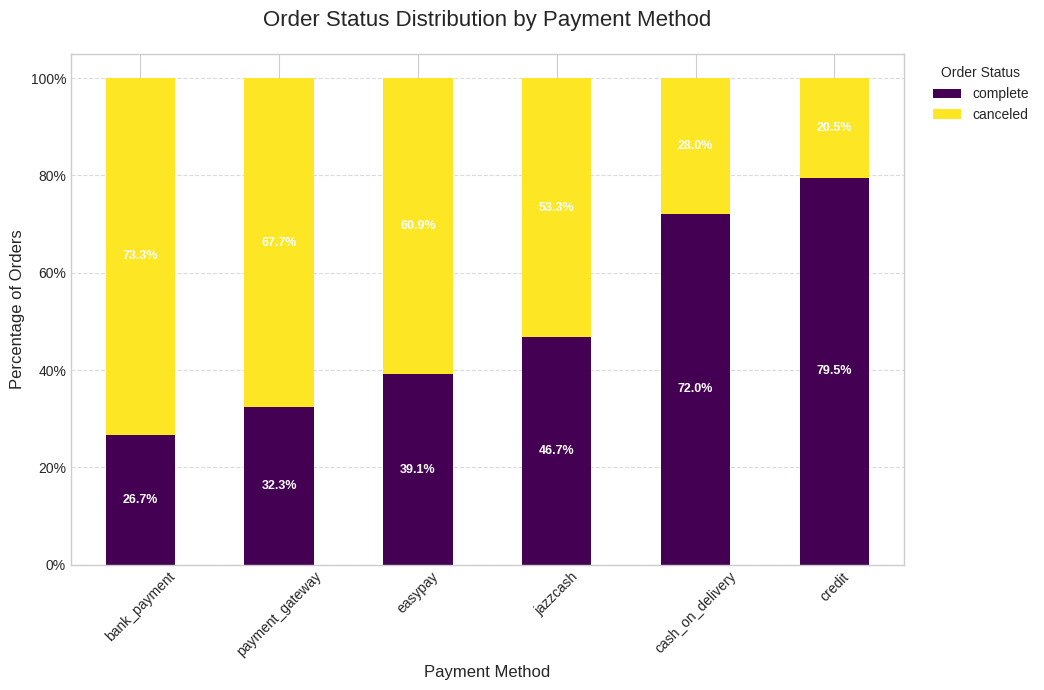


--- Descriptive Analysis Complete ---


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
import os
# Removing chi2_contingency import
from IPython.display import display, HTML

warnings.filterwarnings("ignore")


DATASET_PATH = '/kaggle/input/datascience/preprocessed_dataset.csv'
PAYMENT_COL = 'payment_method'
STATUS_COL = 'status'
TARGET_STATUSES = ['complete', 'canceled']
MIN_ORDERS_PER_METHOD = 20



if not os.path.exists(DATASET_PATH):
    print(f"Error: Dataset file not found at {DATASET_PATH}")
    exit()
else:
    print(f"Loading dataset from: {DATASET_PATH}")
    try:
        df = pd.read_csv(DATASET_PATH)
        print("Dataset loaded successfully.")
        print(f"Original shape: {df.shape}")
    except Exception as e:
        print(f"Error loading dataset from {DATASET_PATH}: {e}")
        exit()


required_cols = [PAYMENT_COL, STATUS_COL]
if not all(col in df.columns for col in required_cols):
    missing = [col for col in required_cols if col not in df.columns]
    print(f"Error: Missing required columns: {', '.join(missing)}")
    exit()


df_analysis = df.dropna(subset=required_cols).copy()


status_df = df_analysis[df_analysis[STATUS_COL].isin(TARGET_STATUSES)].copy()
print(f"\nShape after filtering for statuses {TARGET_STATUSES}: {status_df.shape}")

if status_df.empty:
    print(f"Error: No orders found with statuses {TARGET_STATUSES}. Cannot perform analysis.")
    exit()


if MIN_ORDERS_PER_METHOD > 0:
    payment_counts = status_df[PAYMENT_COL].value_counts()
    valid_methods = payment_counts[payment_counts >= MIN_ORDERS_PER_METHOD].index.tolist()
    original_methods = status_df[PAYMENT_COL].nunique()
    status_df = status_df[status_df[PAYMENT_COL].isin(valid_methods)]
    print(f"Filtered out {original_methods - len(valid_methods)} payment methods with < {MIN_ORDERS_PER_METHOD} orders.")
    print(f"Shape after filtering payment methods: {status_df.shape}")
    if status_df.empty:
        print(f"Error: No orders remaining after filtering payment methods. Adjust MIN_ORDERS_PER_METHOD.")
        exit()


# --- Status Distribution Calculation ---
contingency_table = pd.crosstab(status_df[PAYMENT_COL], status_df[STATUS_COL])
print("\nContingency Table (Payment Method vs Order Status Counts):")
print(contingency_table)


try:
    proportion_table = contingency_table.apply(lambda r: r/r.sum()*100, axis=1)
    print("\nProportion Table (Status % within each Payment Method):")
    if 'complete' not in proportion_table.columns: proportion_table['complete'] = 0
    if 'canceled' not in proportion_table.columns: proportion_table['canceled'] = 0
    sorted_proportion_table = proportion_table[['complete', 'canceled']].sort_values(by='canceled', ascending=False)
    print(sorted_proportion_table.applymap('{:.1f}%'.format))
except ZeroDivisionError:
    print("\nError: Cannot calculate proportions. Some payment methods might have zero total orders after filtering.")
    exit()
except Exception as e:
     print(f"\nAn error occurred calculating proportions: {e}")
     exit()


# --- Visualization ---
print("\n--- Visualization: Order Status by Payment Method ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))


sorted_proportion_table.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    colormap='viridis'
)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Percentage of Orders', fontsize=12)
ax.set_xlabel('Payment Method', fontsize=12)
ax.set_title('Order Status Distribution by Payment Method', fontsize=16, pad=20)
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Order Status', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)


for container in ax.containers:
     try:
          labels = [f"{v:.1f}%" if v > 0.1 else '' for v in container.datavalues]
          ax.bar_label(container, labels=labels, label_type='center', fontsize=9, color='white', weight='bold')
     except AttributeError:
          # Silently skip if labels cannot be added
          pass
     except Exception as e:
          # Silently skip other label errors
          pass


plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()


print("\n--- Descriptive Analysis Complete ---")

## 4. Is there a correlation between payment method and order status? ##


Splitting historical data: Training on first 20 months, Testing on next 6 months.

--- Linear Regression Analysis ---

--- Linear Regression Evaluation Metrics (on Training Data) ---
  Log Scale:
    MSE: 0.0149, RMSE: 0.1219, MAE: 0.0932, R²: 0.8247
  Original Scale:
    MSE: 3,739,887,140,815,470.50, RMSE: 61,154,616.68, MAE: 32,386,991.97, R²: 0.8005
    MAPE: 21.98%
-------------------------------------------------------

--- Linear Regression Evaluation Metrics (on Test Data) ---
  Log Scale:
    MSE: 0.0803, RMSE: 0.2833, MAE: 0.2396, R²: -0.3938
  Original Scale:
    MSE: 14,496,216,892,706,698.00, RMSE: 120,400,236.27, MAE: 100,435,384.35, R²: -0.1395
    MAPE: 47.75%
---------------------------------------------------


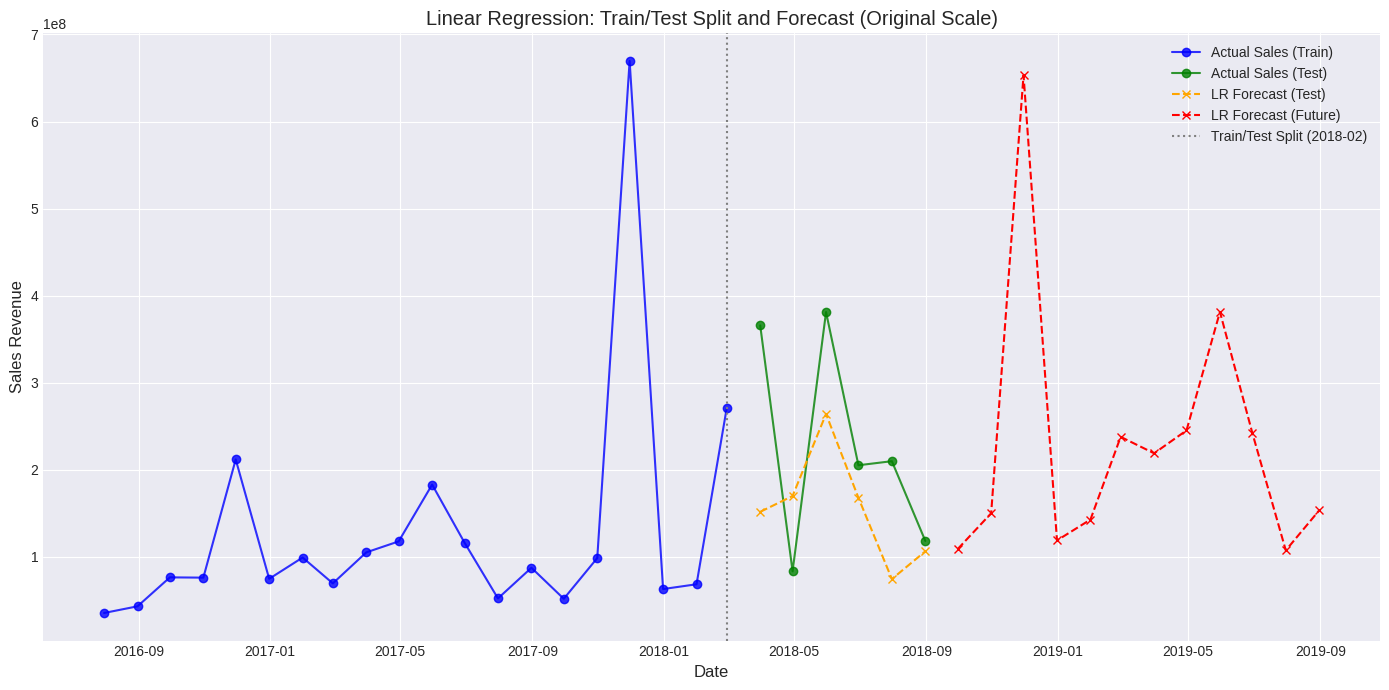


--- Analysis Complete ---


In [15]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
# Removing PolynomialFeatures import
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os
import warnings

# --- Configuration & Setup ---
warnings.filterwarnings('ignore') 
matplotlib.style.use('seaborn-v0_8-darkgrid') 
%matplotlib inline

# --- 1. Data Ingestion ---
# Minimal prints during loading
DATASET_FILEPATH = '/kaggle/input/preprocessed_dataset.csv' 
data_source_path = None
if os.path.exists(DATASET_FILEPATH):
    data_source_path = DATASET_FILEPATH
else:
    for directory_path, _, file_list in os.walk('/kaggle/input'):
        for file_name in file_list:
            if file_name.endswith('.csv'):
                data_source_path = os.path.join(directory_path, file_name)
                break
        if data_source_path:
            break
    if not data_source_path:
        raise FileNotFoundError("No suitable CSV file located.")
        
raw_dataframe = pd.read_csv(data_source_path, low_memory=False) 

# --- 2. Data Transformation & Initial Visualization ---
if 'created_at' not in raw_dataframe.columns or 'grand_total' not in raw_dataframe.columns:
     raise ValueError("Essential columns 'created_at' or 'grand_total' are missing.")

sales_data = raw_dataframe[['created_at','grand_total']].copy()
sales_data.dropna(inplace=True)
sales_data['created_at'] = pd.to_datetime(sales_data['created_at'], errors='coerce')
sales_data.dropna(subset=['created_at'], inplace=True) 
sales_data['grand_total'] = pd.to_numeric(sales_data['grand_total'], errors='coerce')
sales_data.dropna(subset=['grand_total'], inplace=True)

if sales_data.empty:
    raise ValueError("Dataframe is empty after essential cleaning steps.")

sales_data.set_index('created_at', inplace=True)
monthly_summary = sales_data.resample('M').sum() 
monthly_summary.reset_index(inplace=True)

min_value_offset = 1e-5 
monthly_summary['grand_total'] = monthly_summary['grand_total'].apply(lambda x: max(x, min_value_offset))

# Store original historical data before extending
historical_monthly_summary = monthly_summary.copy()
num_historical_months = len(historical_monthly_summary)

# --- 3. Time Series Extension for Forecasting ---
last_historical_date = historical_monthly_summary['created_at'].max()
forecast_start_date = pd.to_datetime('2018-09-30') 
if last_historical_date >= forecast_start_date:
    forecast_start_date = last_historical_date + pd.offsets.MonthEnd(1)
forecast_end_date = pd.to_datetime('2019-08-31') 

if forecast_end_date < forecast_start_date:
     future_periods_index = pd.Index([])
else:
    future_periods_index = pd.date_range(forecast_start_date, forecast_end_date, freq='M')

full_date_range = pd.Index(historical_monthly_summary['created_at']).union(future_periods_index)
date_scaffold_df = pd.DataFrame({'created_at': full_date_range})
# Use historical data for merging to preserve original grand_total before extension
monthly_summary_full = pd.merge(historical_monthly_summary, date_scaffold_df, on='created_at', how='right')

# --- 4. Feature Creation ---
monthly_summary_full['time_index'] = range(1, len(monthly_summary_full) + 1) 
monthly_summary_full['log_sales_target'] = np.log10(monthly_summary_full['grand_total']) # Will have NaNs for future
for month_idx in range(1, 13):
    monthly_summary_full[f'month_is_{month_idx}'] = (monthly_summary_full['created_at'].dt.month == month_idx).astype(int) 

# --- 5. Data Splitting for Modeling (Train/Test Split) ---
n_train_months = 20
n_test_months = num_historical_months - n_train_months

if n_train_months <= 0 or n_test_months <= 0:
     raise ValueError(f"Cannot perform train/test split with {n_train_months} train and {n_test_months} test months from {num_historical_months} available historical months.")
     
print(f"\nSplitting historical data: Training on first {n_train_months} months, Testing on next {n_test_months} months.")

monthly_indicator_cols = [f'month_is_{m}' for m in range(2, 13)] 
feature_set = ['time_index'] + monthly_indicator_cols

# Extract features and targets from the non-extended dataframe for splitting
feature_matrix_historical = monthly_summary_full[monthly_summary_full['grand_total'].notna()][feature_set].copy()
target_log_historical = monthly_summary_full[monthly_summary_full['grand_total'].notna()]['log_sales_target'].copy()
target_orig_historical = np.power(10, target_log_historical)

# Training Set
feature_matrix_train = feature_matrix_historical.iloc[:n_train_months]
target_log_train = target_log_historical.iloc[:n_train_months]
target_orig_train = target_orig_historical.iloc[:n_train_months]

# Test Set
feature_matrix_test = feature_matrix_historical.iloc[n_train_months:]
target_log_test = target_log_historical.iloc[n_train_months:]
target_orig_test = target_orig_historical.iloc[n_train_months:]

# Full feature matrix (including future periods for final forecast)
feature_matrix_full = monthly_summary_full[feature_set].copy() 

# --- Function for Evaluation Metrics ---
def calculate_metrics(y_true_log, y_pred_log, y_true_orig, y_pred_orig):
    metrics = {}
    # Log Scale
    metrics['Log MSE'] = mean_squared_error(y_true_log, y_pred_log)
    metrics['Log RMSE'] = np.sqrt(metrics['Log MSE'])
    metrics['Log MAE'] = mean_absolute_error(y_true_log, y_pred_log)
    metrics['Log R2'] = r2_score(y_true_log, y_pred_log)
    # Original Scale
    metrics['Orig MSE'] = mean_squared_error(y_true_orig, y_pred_orig)
    metrics['Orig RMSE'] = np.sqrt(metrics['Orig MSE'])
    metrics['Orig MAE'] = mean_absolute_error(y_true_orig, y_pred_orig)
    metrics['Orig R2'] = r2_score(y_true_orig, y_pred_orig)
    # MAPE (handling potential zeros)
    mask = y_true_orig != 0
    if np.any(mask):
         metrics['Orig MAPE (%)'] = np.mean(np.abs((y_true_orig[mask] - y_pred_orig[mask]) / y_true_orig[mask])) * 100
    else:
         metrics['Orig MAPE (%)'] = np.nan
    return metrics

def print_metrics(model_name, metrics, data_split_name="Training"):
    print(f"\n--- {model_name} Evaluation Metrics (on {data_split_name} Data) ---")
    print("  Log Scale:")
    print(f"    MSE: {metrics.get('Log MSE', np.nan):.4f}, RMSE: {metrics.get('Log RMSE', np.nan):.4f}, MAE: {metrics.get('Log MAE', np.nan):.4f}, R²: {metrics.get('Log R2', np.nan):.4f}")
    print("  Original Scale:")
    print(f"    MSE: {metrics.get('Orig MSE', np.nan):,.2f}, RMSE: {metrics.get('Orig RMSE', np.nan):,.2f}, MAE: {metrics.get('Orig MAE', np.nan):,.2f}, R²: {metrics.get('Orig R2', np.nan):.4f}")
    print(f"    MAPE: {metrics.get('Orig MAPE (%)', np.nan):.2f}%")
    print("-" * (len(model_name) + len(data_split_name) + 30))

# --- 6. Linear Regression Model ---
print("\n--- Linear Regression Analysis ---")
linear_regressor = LinearRegression() 
# Train ONLY on the training data
linear_regressor.fit(feature_matrix_train, target_log_train) 

# Evaluate on Training Data
lr_pred_log_train = linear_regressor.predict(feature_matrix_train)
lr_pred_orig_train = np.power(10, lr_pred_log_train)
lr_train_metrics = calculate_metrics(target_log_train, lr_pred_log_train, target_orig_train, lr_pred_orig_train)
print_metrics("Linear Regression", lr_train_metrics, data_split_name="Training")

# Evaluate on Test Data
lr_pred_log_test = linear_regressor.predict(feature_matrix_test)
lr_pred_orig_test = np.power(10, lr_pred_log_test)
lr_test_metrics = calculate_metrics(target_log_test, lr_pred_log_test, target_orig_test, lr_pred_orig_test)
print_metrics("Linear Regression", lr_test_metrics, data_split_name="Test")


# Generate full forecast (original scale) using the model trained on training data
lr_full_forecast_log = linear_regressor.predict(feature_matrix_full)
lr_full_forecast_orig = np.power(10, lr_full_forecast_log)

# --- Plotting Train/Test/Forecast ---
plt.figure(figsize=(14, 7))

# Get dates for different splits
train_dates = monthly_summary_full['created_at'].iloc[:n_train_months]
test_dates = monthly_summary_full['created_at'].iloc[n_train_months:num_historical_months]
future_dates = monthly_summary_full['created_at'].iloc[num_historical_months:]

# Plot Actuals
plt.plot(train_dates, target_orig_train, label='Actual Sales (Train)', marker='o', linestyle='-', color='blue', alpha=0.8)
plt.plot(test_dates, target_orig_test, label='Actual Sales (Test)', marker='o', linestyle='-', color='green', alpha=0.8)

# Plot Predictions/Forecast
plt.plot(test_dates, lr_pred_orig_test, label='LR Forecast (Test)', marker='x', linestyle='--', color='orange')
plt.plot(future_dates, lr_full_forecast_orig[num_historical_months:], label='LR Forecast (Future)', marker='x', linestyle='--', color='red') # Plot only future part of full forecast

# Add split line
split_date = train_dates.iloc[-1]
plt.axvline(split_date, color='gray', linestyle=':', label=f'Train/Test Split ({split_date.strftime("%Y-%m")})')

plt.title('Linear Regression: Train/Test Split and Forecast (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- Analysis Complete ---")